In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

4423680/4422102 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


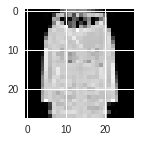

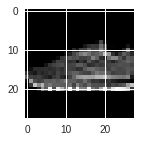

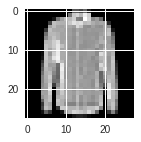

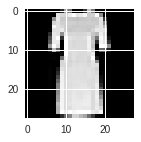

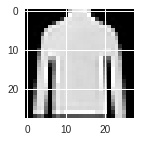

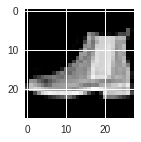

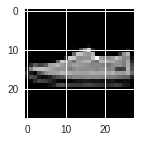

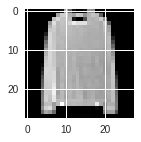

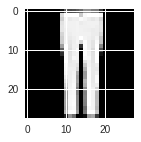

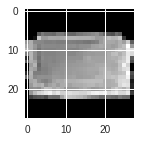

In [3]:
# Printing 10 randomly chosen images
x = np.random.randint(0, len(x_train), size=10)
for i in x:
    plt.figure(figsize=(4, 2))
    plt.imshow(x_train[i], cmap='gray')
    plt.show()

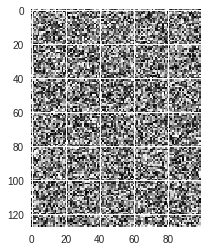

In [4]:
z = np.random.uniform(-1., 1., size=[128, 100])
plt.imshow(z, cmap='gray')

In [0]:
# Flattening the images
x_train = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])

lr_discriminator = 1e-3
lr_generator = 1e-3
training_steps = 12800
batch_size = 128

real_image_input = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
noisy_input = tf.placeholder(tf.float32, shape=[None, 100])

is_training = tf.placeholder(tf.bool)

# LeakyReLU activation
def leaky_relu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)
  
def show_images(sess):  
  # Testing
  # Generate images from noise, using the generator network.
  n = 6
  canvas = np.empty((28 * n, 28 * n))
  for i in range(n):
      # Noise input.
      z = np.random.uniform(-1., 1., size=[n, 100])
      # Generate image from noise.
      g = sess.run(gen_image, feed_dict={noisy_input:z, is_training:False})
      # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
      g = (g + 1.) / 2.
      # Reverse colours for better display
      g = -1 * (g - 1)
      for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

  plt.figure(figsize=(n, n))
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()

In [0]:
def generator(x, is_training, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
        # Input shape = [None, 100]
        ### Fully-connected layer
        x = tf.layers.dense(x, 7*7*128)
        # new shape = [None, 7*7*128]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        ### 1st deconvolutional layer
        x = tf.reshape(x, shape = [-1, 7, 7, 128])
        x = tf.layers.conv2d_transpose(x, 64, kernel_size=5, strides=2, padding='SAME')
        # new shape = [None, 14, 14, 64]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.nn.relu(x)
        ### 2nd deconvolutional layer
        x = tf.layers.conv2d_transpose(x, 1, kernel_size=5, strides=2, padding='SAME')
        # new shape = [None, 28, 28, 1]
        out = tf.nn.tanh(x)
        return out

In [0]:
def discriminator(x, is_training, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input shape = [None, 28, 28, 1]
        ### 1st convolutional layer
        x = tf.layers.conv2d(x, 64, kernel_size=5, strides=2, padding='same')
        # new shape = [None, 14, 14, 64]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leaky_relu(x)
        ### 2nd convolutional layer
        x = tf.layers.conv2d(x, 128, kernel_size=5, strides=2, padding='same')
        # new shape = [None, 7, 7, 128]
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leaky_relu(x)
        
        # Flatten
        x = tf.reshape(x, shape=[-1, 7*7*128])
        ### 1st Fully-connected layer
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leaky_relu(x)
        ### 2nd Fully-connected layer
        out = tf.layers.dense(x, 2)
        # new shape = [None, 2]
        #out = tf.nn.sigmoid(out)
        return out

In [0]:
### Fetching the outputs
gen_image = generator(noisy_input, is_training)
disc_fake = discriminator(gen_image, is_training)
disc_real = discriminator(real_image_input, is_training, reuse=True)

### Loss functions
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_fake, 
                          labels=np.ones([batch_size],dtype=np.int32)))
disc_fake_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_fake,
                          labels=np.zeros([batch_size], dtype=np.int32)))
disc_real_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_real,
                          labels=np.ones([batch_size], dtype=np.int32)))
disc_loss = disc_fake_loss + disc_real_loss

### Optimization of parameters
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=0.5, beta2=0.999)

In [0]:
# We need to specify the parameters that need to be tuned by each optimizers otherwise all parameters will be tuned
# by all the optimizers
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)
    
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [0]:
def get_batch(start, end):
#     print (start, end)
    x = x_train[start:end]
    y = y_train[start:end]
    return x, y

Step: 0 	Discriminator Loss: 1.7150247 	Generator loss: 1.6696805


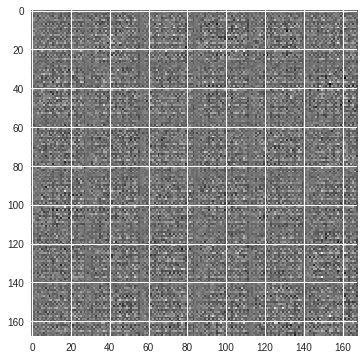

Step: 1 	Discriminator Loss: 7.746419 	Generator loss: 1.3914747


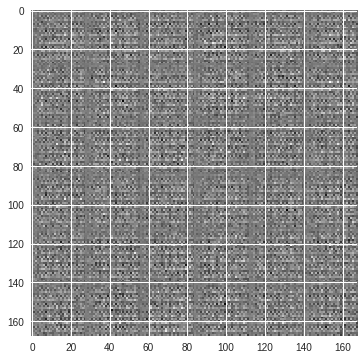

Step: 100 	Discriminator Loss: 0.52598995 	Generator loss: 1.6119069


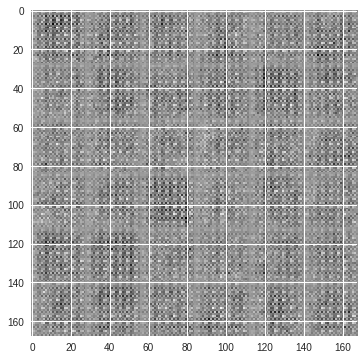

Step: 200 	Discriminator Loss: 0.7454048 	Generator loss: 2.1562984


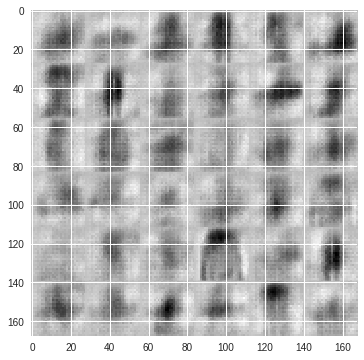

Step: 300 	Discriminator Loss: 0.47177547 	Generator loss: 2.4718738


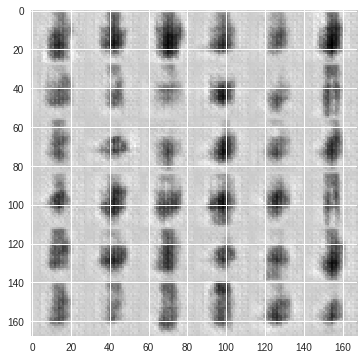

Step: 400 	Discriminator Loss: 0.12950486 	Generator loss: 3.0544825


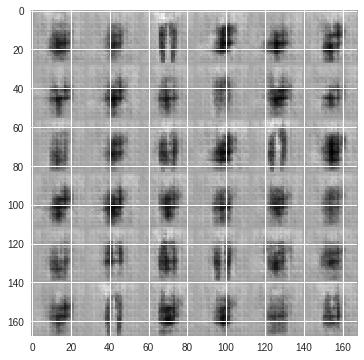

EPOCH COMPLETE at: 467
Step: 500 	Discriminator Loss: 0.23810676 	Generator loss: 3.0674014


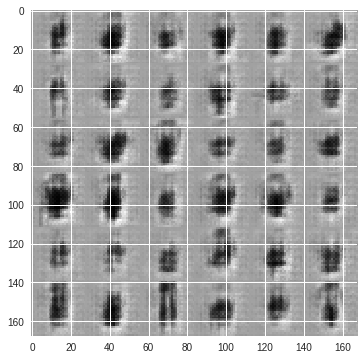

Step: 600 	Discriminator Loss: 0.08887551 	Generator loss: 2.7710986


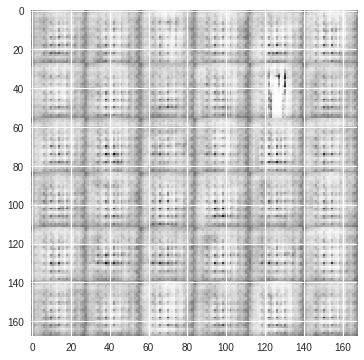

Step: 700 	Discriminator Loss: 0.01936915 	Generator loss: 4.324144


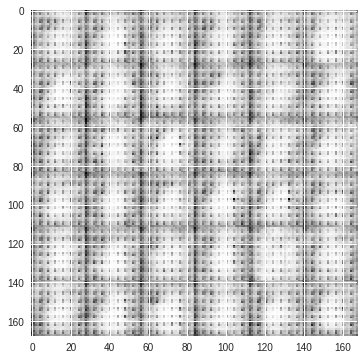

Step: 800 	Discriminator Loss: 0.013105356 	Generator loss: 4.989829


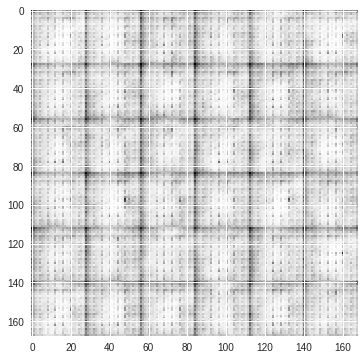

KeyboardInterrupt: ignored

In [11]:
sess = tf.Session()
sess.run(init)

start = 0
end = batch_size

for i in range(training_steps+1):
    batch_x, _ = get_batch(start, end)
#     batch_x, _ = mnist.train.next_batch(batch_size)
#     idx = np.random.randint(0, x_train.shape[0], batch_size)
#     batch_x = x_train[idx]
  
    batch_x = np.reshape(batch_x, newshape=[batch_size, 28, 28, 1])
    batch_x = batch_x * 2. - 1.
    start += batch_size
    end += batch_size
    
    z = np.random.uniform(-1., 1., size=[batch_size, 100])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input:batch_x, noisy_input:z, is_training:True})
    z = np.random.uniform(-1., 1., size=[batch_size, 100])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={noisy_input:z, is_training:True})
    
    if i % 100 == 0 or i == 1:
        print ("Step:", i, "\tDiscriminator Loss:", dl, "\tGenerator loss:", gl)
        show_images(sess)
        
    if end >= len(x_train):
        start = 0
        end = batch_size
        print ("EPOCH COMPLETE at:", i)

### Important Notes (based on issues faced so far)
1) Normalizing output image<br>
2) Normalizing batch input<br>
3) Reshaping with image dimensions/orientations in mind<br>
4) Weights should be initialized using Xavier Glorot initialization otherwise the loss will be inf<br>
5) Sparse_cross_entropy to be used and outputs should be 2 instead of 1 (since it's one-hot encoded)<br>
